In [62]:
import torch
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import cv2
import seaborn as sns


import torch.quantization
from torchvision.models import vgg11, VGG11_Weights

In [63]:
def transform(img_x):
    #normalize image x
    transform = transforms.Compose([
        transforms.ToTensor(),
        #using mean and standard deviation of imagenet dataset
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.Resize((221, 221), antialias=True)
    ])
    return transform(img_x)

In [64]:
def compute_similarity_matrix(feature_vectors):
    """
    Compute the similarity matrix for visual loop closure detection.

    Args:
        feature_vectors (np.ndarray): CNN feature vectors of shape (n_images, 500).

    Returns:
        np.ndarray: Similarity matrix of shape (n_images, n_images).
    """
    feature_vectors = feature_vectors.reshape(feature_vectors.shape[0], -1)
    #print("Feature Vectors Shape:", feature_vectors.shape)
    normalized_vectors = feature_vectors / np.linalg.norm(feature_vectors, axis=1, keepdims=True)
    n_images = normalized_vectors.shape[0]
    
    #print("Normalized Vectors Shape:", normalized_vectors.shape)
    #print('n_images:', n_images)
    
    distances = np.zeros((n_images, n_images))
    for i in range(n_images):
        for j in range(n_images):
            distances[i, j] = np.linalg.norm(normalized_vectors[i] - normalized_vectors[j])
            #print(distances)

    max_distance = np.max(distances)
    #print(max_distance)
    similarity_matrix = 1 - (distances / max_distance)

    return similarity_matrix

In [67]:
#GLOBALS


image_dirs = ['data/data/CityCentre_Images',
              'data/data/NewCollege_Images']
gt_matrix_paths = ['data/data/CityCentreTextFormat.txt',
                   'data/data/NewCollegeTextFormat.txt']

# Focal length:
fc = [ 367.481519978327754 , 366.991059667167065 ]
# Principal point:
cc = [ 328.535778962615268 , 233.779960757465176 ]
# Distortion coefficients:
kc = [ -0.293510277812333,0.065334967950619, -0.000117308680498, 0.000304779905426,0.000000000000000 ]

# Camera matrix
camera_matrix = np.array([
    [fc[0], 0, cc[0]],
    [0, fc[1], cc[1]],
    [0, 0, 1]
], dtype=np.float32)

# Distortion coefficients
dist_coeffs = np.array(kc, dtype=np.float32)


0it [00:00, ?it/s]

Using device: cuda


1073it [00:13, 81.14it/s]


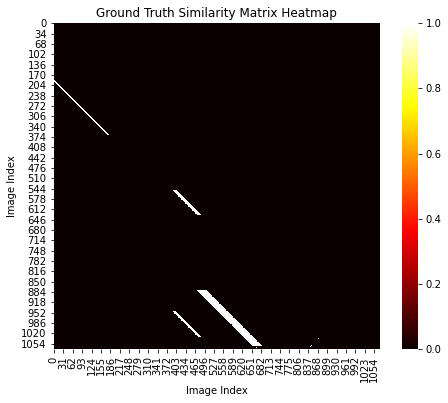

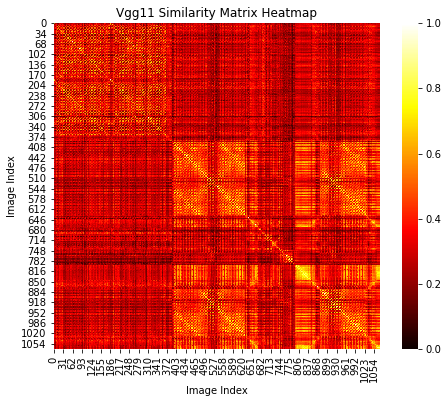

In [75]:
model_vgg11 = vgg11(weights=VGG11_Weights.DEFAULT)
model_vgg11.classifier = torch.nn.Sequential(*list(model_vgg11.classifier.children())[:-3])

torch.save(model_vgg11.state_dict(), "temp.p")
print('Non-Quantized VGG11 Size (MB):', os.path.getsize("temp.p")/1e6)
os.remove('temp.p')

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print('Using device:', device)

model_vgg11.to(device)
model_vgg11.eval()

features_list = []
image_files = sorted(os.listdir(image_dirs[1]))
n=1073 #Number of images in dataset we want show the 

for i, row in tqdm(enumerate(image_files[0:n])):
    img1_path = os.path.join(image_dirs[1], row)
    img1 = cv2.imread(img1_path)
    undistorted_img1 = cv2.undistort(img1, camera_matrix, dist_coeffs)
    transformed_img1 = transform(undistorted_img1)
    img1 = transformed_img1.to(device)
    with torch.no_grad():
        features1 = model_vgg11(img1.unsqueeze(0))
    features_list.append(features1.cpu())
       
feature_vectors = np.vstack(features_list)
similarity_matrix = compute_similarity_matrix(feature_vectors)



gt_matrix = np.loadtxt(gt_matrix_paths[1], delimiter=',')

plt.figure(figsize=(8,6))
sns.heatmap(gt_matrix[0:n,0:n ], annot=False, cmap="hot", square=True)
plt.title("Ground Truth Similarity Matrix Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")

plt.figure(figsize=(8,6))
sns.heatmap(similarity_matrix, annot=False, cmap="hot", square=True)
plt.title("Vgg11 Similarity Matrix Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")
plt.show()



In [83]:
class QuantizedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model_fp32 = model
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        
    def forward(self, x):
        x = self.quant(x)
        x = self.model_fp32(x)
        x = self.dequant(x)
        return x


Using device: cpu


2it [00:00, 17.86it/s]

Quantized VGG11 Size (MB): 128.812622


1073it [00:40, 26.23it/s]


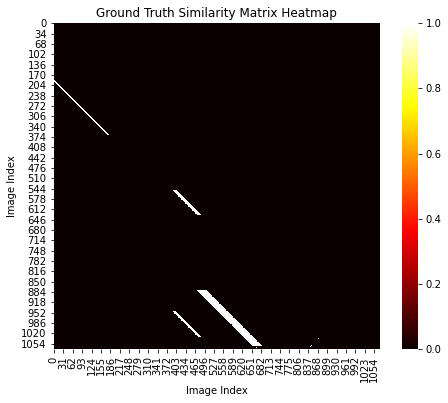

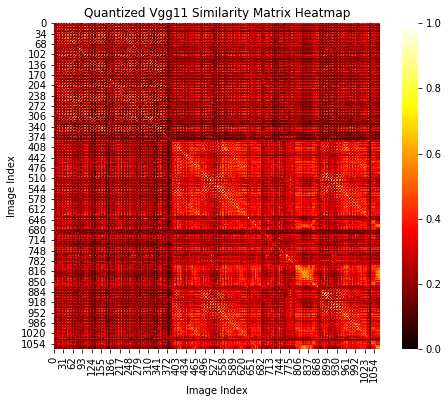

In [93]:
device = torch.device("cpu")
print('Using device:', device)

model_vgg11 = vgg11(weights=VGG11_Weights.DEFAULT)
model_vgg11.classifier = torch.nn.Sequential(*list(model_vgg11.classifier.children())[:-3])
model_vgg11_q = QuantizedModel(model_vgg11)
model_vgg11_q.qconfig = torch.quantization.default_qconfig
torch.quantization.prepare(model_vgg11_q, inplace=True)
torch.quantization.convert(model_vgg11_q, inplace=True)

torch.save(model_vgg11_q.state_dict(), "temp.p")
print('Quantized VGG11 Size (MB):', os.path.getsize("temp.p")/1e6)
os.remove('temp.p')

model_vgg11_q.to(device)
model_vgg11_q.eval()

features_list = []
image_files = sorted(os.listdir(image_dirs[1]))
n=1073 #Number of images in dataset we want show the 

for i, row in tqdm(enumerate(image_files[0:n])):
    img1_path = os.path.join(image_dirs[1], row)
    img1 = cv2.imread(img1_path)
    undistorted_img1 = cv2.undistort(img1, camera_matrix, dist_coeffs)
    transformed_img1 = transform(undistorted_img1)
    img1 = transformed_img1.to(device)
    with torch.no_grad():
        features1 = model_vgg11_q(img1.unsqueeze(0))
    features_list.append(features1.cpu())
       
feature_vectors = np.vstack(features_list)
similarity_matrix = compute_similarity_matrix(feature_vectors)



gt_matrix = np.loadtxt(gt_matrix_paths[1], delimiter=',')

plt.figure(figsize=(8,6))
sns.heatmap(gt_matrix[0:n,0:n ], annot=False, cmap="hot", square=True)
plt.title("Ground Truth Similarity Matrix Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")

plt.figure(figsize=(8,6))
sns.heatmap(similarity_matrix, annot=False, cmap="hot", square=True)
plt.title("Quantized Vgg11 Similarity Matrix Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")
plt.show()

